In [80]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
import re
import math
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor,DecisionTreeRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler
import pandas as pd
spark = SparkSession.builder.appName('example code').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext
spark.conf.set('spark.sql.session.timeZone', 'UTC')
bitcoin_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('Symbol', types.StringType()),
    types.StructField('Open', types.FloatType()),
    types.StructField('High', types.FloatType()),
    types.StructField('Low', types.FloatType()),
    types.StructField('Close', types.FloatType()),
    types.StructField('Volume BTC', types.FloatType()),
    types.StructField('Volume USD', types.FloatType()),
])

In [81]:
col_order = ["timestamp", "Open", "High", "Low", "Close", "Volume BTC", "Volume USD", "Weighted"]
features = ["Open", "High", "Low", "Close", "Weighted"]
#col_order = ["timestamp", "Close"]
w =Window.partitionBy().orderBy(functions.col("timestamp").cast('long'))
lag =3
diff_lst = [i for i in range(1, lag+1)]

In [82]:
data = spark.read.csv("bitcoin-usd-history.csv", schema=bitcoin_schema).na.drop().cache()
data = data.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd hh-aa').cast("timestamp")).drop('Date')
data = data.withColumn("Weighted", data["Volume USD"] / (data["Volume BTC"] + sys.float_info.min))
data = data.select(col_order).sort("timestamp").cache()
data.show()

+-------------------+-------+-------+-------+-------+----------+----------+------------------+
|          timestamp|   Open|   High|    Low|  Close|Volume BTC|Volume USD|          Weighted|
+-------------------+-------+-------+-------+-------+----------+----------+------------------+
|2017-07-01 11:00:00| 2562.3|2580.99| 2554.0| 2568.0|      3.04|   7781.15| 2559.588815784314|
|2017-07-01 12:00:00| 2568.0|2577.79|2555.01|2576.58|      11.0|  28231.42|2566.4927201704545|
|2017-07-01 13:00:00|2576.58|2576.58|2555.01|2555.08|     14.23|  36482.36|2563.7639176808143|
|2017-07-01 14:00:00|2555.08| 2570.0| 2555.0|2556.01|     18.34|  47008.07| 2563.144488625692|
|2017-07-01 15:00:00|2556.01| 2570.0| 2555.0| 2564.2|     18.34|  46953.85|2560.1881773089576|
|2017-07-01 16:00:00| 2564.2|2568.99| 2555.0| 2565.0|      8.93|  22907.08|2565.1824518805647|
|2017-07-01 17:00:00| 2565.0| 2565.0| 2549.6| 2550.0|     24.88|  63592.23|2555.9579024837312|
|2017-07-01 18:00:00| 2550.0| 2560.0|2537.07|2537.

In [83]:
feature_df = data.select(col_order)
feature_df.show()

+-------------------+-------+-------+-------+-------+----------+----------+------------------+
|          timestamp|   Open|   High|    Low|  Close|Volume BTC|Volume USD|          Weighted|
+-------------------+-------+-------+-------+-------+----------+----------+------------------+
|2017-07-01 11:00:00| 2562.3|2580.99| 2554.0| 2568.0|      3.04|   7781.15| 2559.588815784314|
|2017-07-01 12:00:00| 2568.0|2577.79|2555.01|2576.58|      11.0|  28231.42|2566.4927201704545|
|2017-07-01 13:00:00|2576.58|2576.58|2555.01|2555.08|     14.23|  36482.36|2563.7639176808143|
|2017-07-01 14:00:00|2555.08| 2570.0| 2555.0|2556.01|     18.34|  47008.07| 2563.144488625692|
|2017-07-01 15:00:00|2556.01| 2570.0| 2555.0| 2564.2|     18.34|  46953.85|2560.1881773089576|
|2017-07-01 16:00:00| 2564.2|2568.99| 2555.0| 2565.0|      8.93|  22907.08|2565.1824518805647|
|2017-07-01 17:00:00| 2565.0| 2565.0| 2549.6| 2550.0|     24.88|  63592.23|2555.9579024837312|
|2017-07-01 18:00:00| 2550.0| 2560.0|2537.07|2537.

In [84]:
for feature in features:
    for diff in diff_lst:
        name = feature + "_lag_{}".format(diff)
        feature_df = feature_df.withColumn(name, functions.lag(feature_df[feature], count=diff).over(w))

feature_df = feature_df.na.drop()
feature_df.show(2)

+-------------------+-------+------+------+-------+----------+----------+------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-----------+-----------+-----------+------------------+------------------+------------------+
|          timestamp|   Open|  High|   Low|  Close|Volume BTC|Volume USD|          Weighted|Open_lag_1|Open_lag_2|Open_lag_3|High_lag_1|High_lag_2|High_lag_3|Low_lag_1|Low_lag_2|Low_lag_3|Close_lag_1|Close_lag_2|Close_lag_3|    Weighted_lag_1|    Weighted_lag_2|    Weighted_lag_3|
+-------------------+-------+------+------+-------+----------+----------+------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-----------+-----------+-----------+------------------+------------------+------------------+
|2017-07-01 14:00:00|2555.08|2570.0|2555.0|2556.01|     18.34|  47008.07| 2563.144488625692|   2576.58|    2568.0|    2562.3|   2576.58|   2577.79|   2580

In [85]:
feature_df = feature_df.withColumn("Next Close", functions.lag(data["Close"], count=-1).over(w))
feature_df = feature_df.na.drop()
feature_df.show(2)

+-------------------+-------+------+------+-------+----------+----------+------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-----------+-----------+-----------+------------------+------------------+------------------+----------+
|          timestamp|   Open|  High|   Low|  Close|Volume BTC|Volume USD|          Weighted|Open_lag_1|Open_lag_2|Open_lag_3|High_lag_1|High_lag_2|High_lag_3|Low_lag_1|Low_lag_2|Low_lag_3|Close_lag_1|Close_lag_2|Close_lag_3|    Weighted_lag_1|    Weighted_lag_2|    Weighted_lag_3|Next Close|
+-------------------+-------+------+------+-------+----------+----------+------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-----------+-----------+-----------+------------------+------------------+------------------+----------+
|2017-07-01 14:00:00|2555.08|2570.0|2555.0|2556.01|     18.34|  47008.07| 2563.144488625692|   2576.58|    2568.0|    256

In [86]:
featureCols = []
for feature in features:
    featureCols.append(feature)
    for diff in diff_lst:
        featureCols.append(feature + "_lag_{}".format(diff))
featureCols

['Open',
 'Open_lag_1',
 'Open_lag_2',
 'Open_lag_3',
 'High',
 'High_lag_1',
 'High_lag_2',
 'High_lag_3',
 'Low',
 'Low_lag_1',
 'Low_lag_2',
 'Low_lag_3',
 'Close',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'Weighted',
 'Weighted_lag_1',
 'Weighted_lag_2',
 'Weighted_lag_3']

In [87]:
assembler = VectorAssembler(
        inputCols=featureCols,
        outputCol='features'

)

regressor = RandomForestRegressor(
    featuresCol='features',
    labelCol='Next Close',
    featureSubsetStrategy="auto", 
    impurity= "variance",
    numTrees=20,
    maxDepth=5,
    maxBins=32,
    seed=13579
    
)

In [88]:
#scaledData.select("features", "scaledFeatures").show()

In [89]:
train, validation = feature_df.randomSplit([0.75, 0.25])
train = train.cache()
validation = validation.cache()
train.show(2)

+-------------------+-------+-------+------+------+----------+----------+------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-----------+-----------+-----------+------------------+------------------+------------------+----------+
|          timestamp|   Open|   High|   Low| Close|Volume BTC|Volume USD|          Weighted|Open_lag_1|Open_lag_2|Open_lag_3|High_lag_1|High_lag_2|High_lag_3|Low_lag_1|Low_lag_2|Low_lag_3|Close_lag_1|Close_lag_2|Close_lag_3|    Weighted_lag_1|    Weighted_lag_2|    Weighted_lag_3|Next Close|
+-------------------+-------+-------+------+------+----------+----------+------------------+----------+----------+----------+----------+----------+----------+---------+---------+---------+-----------+-----------+-----------+------------------+------------------+------------------+----------+
|2017-07-01 15:00:00|2556.01| 2570.0|2555.0|2564.2|     18.34|  46953.85|2560.1881773089576|   2555.08|   2576.58|    256

In [90]:
pipeline = Pipeline(stages=[assembler, regressor])
model = pipeline.fit(train)

In [91]:
predictions = model.transform(validation)
pred_df = predictions.select("Next Close", "prediction")
pred_df.show(3)

+----------+------------------+
|Next Close|        prediction|
+----------+------------------+
|    2564.2|2476.3047669910693|
|    2531.0|2476.3047669910693|
|    2505.0|2476.3047669910693|
+----------+------------------+
only showing top 3 rows



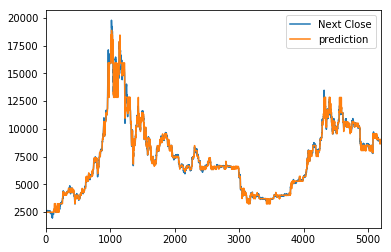

In [92]:
pred_pdf= pred_df.toPandas()
pred_pdf.plot(y=["Next Close", "prediction"])

In [93]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
score = evaluator.evaluate(predictions)

print('R square error is: %g' % (score))

R square error is: 0.995684


In [94]:
model.stages[-1].featureImportances

SparseVector(20, {0: 0.1614, 1: 0.0074, 2: 0.0, 3: 0.0057, 4: 0.2005, 5: 0.0344, 6: 0.0009, 7: 0.0002, 8: 0.0703, 9: 0.0247, 10: 0.0058, 11: 0.0011, 12: 0.2719, 13: 0.0432, 14: 0.0114, 15: 0.0, 16: 0.0626, 17: 0.0575, 18: 0.0162, 19: 0.0247})

In [95]:
model.write().overwrite().save("bitcoin_model_OHLCW")

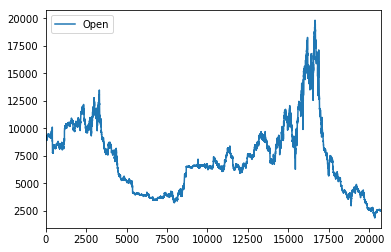

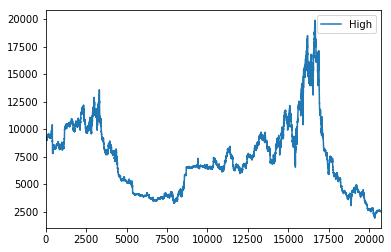

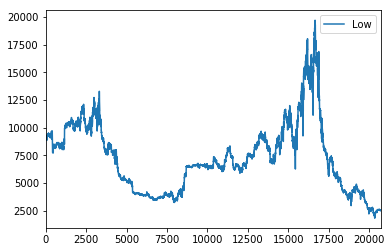

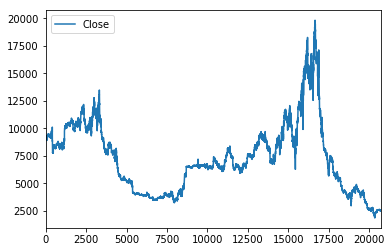

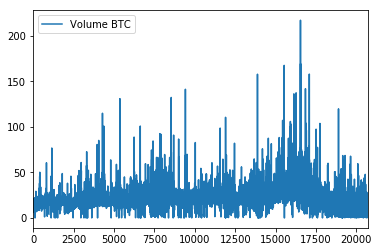

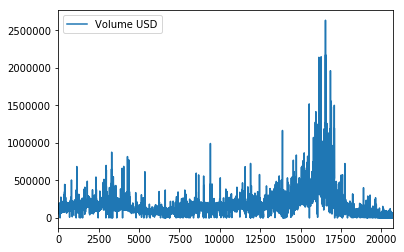

In [27]:
pdf1=data.select(col_order[2:]).toPandas()
# ax = pdf1.plot('Delta') 
for feature in col_order[2:]:
    pdf1.plot(y=feature)
# plot(y='MA_{}'.format(lag),colormap='winter_r')

In [ ]:
#j